In [6]:
import json
import math
import os

#import cv2
!pip install keras
!pip install tensorflow
from PIL import Image
import numpy as np
from keras import layers
from keras.applications import DenseNet121
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
import tensorflow as tf
from tqdm import tqdm

%matplotlib inline

    100% |████████████████████████████████| 86.3MB 464kB/s eta 0:00:01  6% |██                              | 5.5MB 11.8MB/s eta 0:00:07    63% |████████████████████▎           | 54.8MB 12.1MB/s eta 0:00:03
    100% |████████████████████████████████| 112kB 11.6MB/s ta 0:00:01
    100% |████████████████████████████████| 71kB 9.5MB/s eta 0:00:01
    100% |████████████████████████████████| 1.3MB 9.8MB/s eta 0:00:01
    100% |████████████████████████████████| 61kB 10.9MB/s ta 0:00:01
    100% |████████████████████████████████| 3.8MB 5.3MB/s eta 0:00:01
    100% |████████████████████████████████| 450kB 10.6MB/s ta 0:00:01
    100% |████████████████████████████████| 2.4MB 8.9MB/s eta 0:00:01
    100% |████████████████████████████████| 81kB 11.0MB/s ta 0:00:01
    100% |████████████████████████████████| 92kB 10.3MB/s ta 0:00:01
    100% |████████████████████████████████| 133kB 10.4MB/s ta 0:00:01


    100% |████████████████████████████████| 81kB 7.2MB/s ta 0:00:011
    100% |████████████████████████████████| 153kB 11.1MB/s ta 0:00:01
  Stored in directory: /home/mohit/.cache/pip/wheels/7c/06/54/bc84598ba1daf8f970247f550b175aaaee85f68b4b0c5ab2c6
  Stored in directory: /home/mohit/.cache/pip/wheels/8e/28/49/fad4e7f0b9a1227708cbbee4487ac8558a7334849cb81c813d
  Stored in directory: /home/mohit/.cache/pip/wheels/2c/b1/94/43d03e130b929aae7ba3f8d15cbd7bc0d1cb5bb38a5c721833
  Stored in directory: /home/mohit/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built termcolor absl-py opt-einsum gast
tensorboard 2.0.2 has requirement setuptools>=41.0.0, but you'll have setuptools 40.8.0 which is incompatible.


Using TensorFlow backend.


In [8]:
#np.random.seed(2019)
#tf.set_random_seed(2019)

In [9]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
print(train_df.shape)
print(test_df.shape)
train_df.head()

(3662, 2)
(1928, 1)


,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

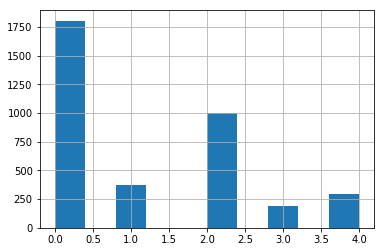

In [10]:
train_df['diagnosis'].hist()
train_df['diagnosis'].value_counts()

In [11]:
def get_pad_width(im, new_shape, is_rgb=True):
    pad_diff = new_shape - im.shape[0], new_shape - im.shape[1]
    t, b = math.floor(pad_diff[0]/2), math.ceil(pad_diff[0]/2)
    l, r = math.floor(pad_diff[1]/2), math.ceil(pad_diff[1]/2)
    if is_rgb:
        pad_width = ((t,b), (l,r), (0, 0))
    else:
        pad_width = ((t,b), (l,r))
    return pad_width

def preprocess_image(image_path, desired_size=224):
    im = Image.open(image_path)
    im = im.resize((desired_size, )*2, resample=Image.LANCZOS)
    
    return im

In [12]:
N = train_df.shape[0]
x_train = np.empty((N, 224, 224, 3), dtype=np.uint8)

for i, image_id in enumerate(tqdm(train_df['id_code'])):
    x_train[i, :, :, :] = preprocess_image(f'train_images/{image_id}.png')

  6%|▌         | 220/3662 [00:34<07:32,  7.61it/s]

KeyboardInterrupt: 

In [43]:
N = test_df.shape[0]
x_test = np.empty((N, 224, 224, 3), dtype=np.uint8)

for i, image_id in enumerate(tqdm(test_df['id_code'])):
    x_test[i, :, :, :] = preprocess_image(f'test_images/{image_id}.png')

100%|██████████| 1928/1928 [01:37<00:00, 19.69it/s]


In [44]:
y_train = pd.get_dummies(train_df['diagnosis']).values

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)


(3662, 224, 224, 3)
(3662, 5)
(1928, 224, 224, 3)


In [45]:
y_train_multi = np.empty(y_train.shape, dtype=y_train.dtype)
y_train_multi[:, 4] = y_train[:, 4]

for i in range(3, -1, -1):
    y_train_multi[:, i] = np.logical_or(y_train[:, i], y_train_multi[:, i+1])

print("Original y_train:", y_train.sum(axis=0))
print("Multilabel version:", y_train_multi.sum(axis=0))

Original y_train: [1805  370  999  193  295]
Multilabel version: [3662 1857 1487  488  295]


In [46]:
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train_multi, 
    test_size=0.15, 
    random_state=2019
)

In [47]:
class Metrics(Callback):
   def build_model():
    model = Sequential()
    model.add(Conv2D(1024, kernel_size=3, activation='relu', input_shape=(224,224,3)))
    #model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.8))
        
    model.add(Conv2D(512, kernel_size=3, activation='relu'))
    #model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.8))
    
    model.add(Conv2D(128, kernel_size=3, activation='relu'))
    #model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.8))
    
    model.add(Conv2D(16, kernel_size=3, activation='relu'))
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(5, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=keras.optimizers.Adam(lr=0.00005),
        metrics=['accuracy']
    )
    
    return model def on_train_begin(self, logs={}):
        self.val_kappas = []

    def on_epoch_end(self, epoch, logs={}):
        X_val, y_val = self.validation_data[:2]
        y_val = y_val.sum(axis=1) - 1
        
        y_pred = self.model.predict(X_val) > 0.5
        y_pred = y_pred.astype(int).sum(axis=1) - 1

        _val_kappa = cohen_kappa_score(
            y_val,
            y_pred, 
            weights='quadratic'
        )

        self.val_kappas.append(_val_kappa)

        print(f"val_kappa: {_val_kappa:.4f}")
        
        if _val_kappa == max(self.val_kappas):
            print("Validation Kappa has improved. Saving model.")
            self.model.save('model.h5')

        return

In [48]:
densenet = DenseNet121(
    weights='DenseNet-BC-121-32-no-top.h5',
    include_top=False,
    input_shape=(224,224,3)
)

In [53]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten
from keras import layers
import keras

def build_model():
    model = Sequential()
    model.add(densenet)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=0.00005),
        metrics=['accuracy']
    )
    
    return model

In [54]:
model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 222, 222, 1024)    28672     
_________________________________________________________________
dropout_20 (Dropout)         (None, 222, 222, 1024)    0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 220, 220, 512)     4719104   
_________________________________________________________________
dropout_21 (Dropout)         (None, 220, 220, 512)     0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 218, 218, 128)     589952    
_________________________________________________________________
dropout_22 (Dropout)         (None, 218, 218, 128)     0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 216, 216, 16)      18448     
__________

In [55]:
BATCH_SIZE = 32

def create_datagen():
    return ImageDataGenerator(
        zoom_range=0.15,  # set range for random zoom
        # set mode for filling points outside the input boundaries
        fill_mode='constant',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )

# Using original generator
data_generator = create_datagen().flow(x_train, y_train, batch_size=BATCH_SIZE, seed=2019)

In [ ]:
kappa_metrics = Metrics()

history = model.fit_generator(
    data_generator,
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=15,
    validation_data=(x_val, y_val),
    callbacks=[kappa_metrics]
)


Epoch 1/15


In [ ]:
with open('history.json', 'w') as f:
    json.dump(history.history, f)

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['acc', 'val_acc']].plot()

In [ ]:
plt.plot(kappa_metrics.val_kappas)

In [17]:
y_test = model.predict(x_test) > 0.5
y_test = y_test.astype(int).sum(axis=1) - 1

test_df['diagnosis'] = y_test
test_df.to_csv('submission.csv',index=False)

In [18]:
test_df.head

<bound method NDFrame.head of            id_code  diagnosis
0     0005cfc8afb6          0
1     003f0afdcd15         -1
2     006efc72b638          0
3     00836aaacf06          0
4     009245722fa4          0
...            ...        ...
1923  ff2fd94448de          1
1924  ff4c945d9b17          0
1925  ff64897ac0d8          0
1926  ffa73465b705          1
1927  ffdc2152d455          1

[1928 rows x 2 columns]>